<a href="https://colab.research.google.com/github/yoooniverse/NLP/blob/main/NaverShoppingReviewSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

02.26.2023

네이버 쇼핑 리뷰 감성 분류하기  
Naver Shopping Review Sentiment Analysis

다운로드 링크 : https://github.com/bab2min/corpus/tree/master/sentiment

In [ ]:
# to use Mecab in Colab
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f81088137f0>)

In [27]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('# of reviews :', len(total_data))

# of reviews : 200000


In [5]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [28]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [29]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [30]:
total_data.drop_duplicates(subset=['reviews'], inplace=True)
print('# of reviews :', len(total_data))

# of reviews : 199908


In [31]:
print(total_data.isnull().values.any())

False


In [32]:
train_data, test_data = train_test_split(total_data, test_size=0.25, random_state=42)
print('# of train_data :', len(train_data))
print('# of test_data :', len(test_data))

# of train_data : 149931
# of test_data : 49977


<AxesSubplot:>

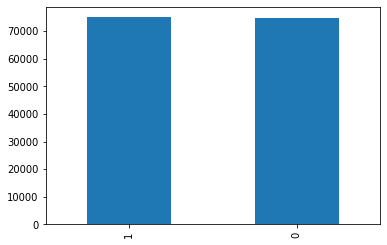

In [14]:
train_data['label'].value_counts().plot(kind='bar')

In [33]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  74918
1      1  75013


In [34]:
#cleaning data

train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
train_data['reviews'] = train_data['reviews'].str.replace('^ +', "")
print(train_data.isnull().sum())

<ipython-input-34-6fdca294d0e0>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")


ratings    0
reviews    0
label      0
dtype: int64


<ipython-input-34-6fdca294d0e0>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace('^ +', "")


In [35]:
test_data.drop_duplicates(subset=['reviews'], inplace=True)
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
test_data['reviews'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
print('# of test_data :', len(test_data))

# of test_data : 49977


<ipython-input-35-66ca76e62a78>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")


In [36]:
#tokenization
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [37]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [38]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [39]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [40]:
# check word and length distribution
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [41]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]
[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


average length of positive reviews : 13.587711463346354
average length of negative reviews : 17.029472222963772


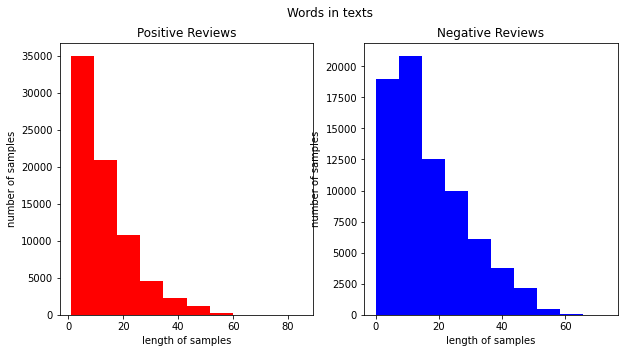

In [42]:
# average length of negative & positive review

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('average length of positive reviews :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('average length of negative reviews :', np.mean(text_len))

plt.show()

In [43]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values

X_test = test_data['tokenized'].values
y_test = test_data['label'].values

In [44]:
#integer encoding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [46]:
threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  total_freq += value

  if (value < threshold) :
    rare_cnt += 1
    rare_freq += value


print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39996
등장 빈도가 1번 이하인 희귀 단어의 수: 18212
단어 집합에서 희귀 단어의 비율: 45.53455345534553
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7935273405723314


In [47]:
vocab_size = total_cnt - rare_cnt + 2
print('vocab_size :', vocab_size)

vocab_size : 21786


In [50]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

print(X_train[:3])

[[67, 2060, 299, 14260, 263, 73, 6, 236, 168, 137, 805, 2951, 625, 2, 77, 62, 207, 40, 1343, 155, 3, 6], [482, 409, 52, 8530, 2562, 2517, 339, 2918, 250, 2358, 38, 473, 2], [46, 24, 828, 105, 35, 2372, 160, 7, 10, 8061, 4, 1319, 29, 140, 322, 41, 59, 160, 140, 7, 1916, 2, 113, 162, 1379, 323, 119, 136]]


longest review : 85
average length : 15.307501450667306
average length : 15.307501450667306


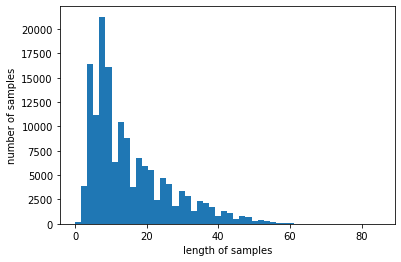

In [51]:
#padding
print('longest review :', max(len(review) for review in X_train))
print('average length :', sum(len(review) for review in X_train) / len(X_train))
print('average length :', sum(map(len, X_train)) / len(X_train))

plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [52]:
#finding best 'max_len' value for padding sequence
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
      count += 1
  print('Proportion of samples with length less than %s out of total samples : %s' %(max_len, (count / len(nested_list))*100))

In [53]:
max_len = 80
below_threshold_len(max_len, X_train)

Proportion of samples with length less than 80 out of total samples : 99.99933302652553


In [54]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

build model

In [55]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units =128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
histry = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2954 - acc: 0.8862
Epoch 1: val_acc improved from -inf to 0.90583, saving model to best_model.h5
1875/1875 [==============================] - 66s 31ms/step - loss: 0.2954 - acc: 0.8862 - val_loss: 0.2559 - val_acc: 0.9058
Epoch 2/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2307 - acc: 0.9172
Epoch 2: val_acc improved from 0.90583 to 0.92040, saving model to best_model.h5
1875/1875 [==============================] - 18s 9ms/step - loss: 0.2307 - acc: 0.9172 - val_loss: 0.2231 - val_acc: 0.9204
Epoch 3/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2074 - acc: 0.9261
Epoch 3: val_acc improved from 0.92040 to 0.92323, saving model to best_model.h5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.2074 - acc: 0.9261 - val_loss: 0.2127 - val_acc: 0.9232
Epoch 4/15
1875/1875 [==============================] - ETA: 0s - loss: 0.1931 - acc: 0.9314
Epoch 4: val_ac

In [57]:
loaded_model = load_model('best_model.h5')
print("test accuracy : %.4f" %(loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 11s 6ms/step - loss: 0.2201 - acc: 0.9212
test accuracy : 0.9212


In [58]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)
  score = float(loaded_model.predict(pad_new))

  if (score > 0.5):
    print("{:.2f}% positive review\n".format(score * 100))
  else :
    print("{:.2f}% negative review\n".format((1-score) * 100))

In [59]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

1/1 [==============================] - 1s 682ms/step
93.89% positive review



In [60]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

1/1 [==============================] - 0s 136ms/step
99.65% negative review



In [61]:
sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')

1/1 [==============================] - 0s 22ms/step
96.02% positive review



In [62]:
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')

1/1 [==============================] - 0s 21ms/step
92.39% negative review

